# HW 1 - Data Platform IDC
ID1: 308564293

ID2: 311898746

## Step 1: Setup Cassandra Cluster locally -

> Code is in markdown as we don't want to run this from the notebook
> The setup is oriented for mac env

Make sure Docker Desktop is installed. If not, download and install Docker from the official website [Get Docker | Docker Docs](https://docs.docker.com/get-docker/).

Download docker image for cassandra
```bash
docker pull cassandra:latest
```

Run container locally open for conncetion from the notebook
```bash
docker run --volume=/var/lib/cassandra --restart=no -p 127.0.0.1:9042:9042 -p 127.0.0.1:9160:9160 --name hw-cass -d cassandra:latest
```

Connect to run `cqlsh` locally
```bash
docker exec -it hw-cass cqlsh
```

## Step 2: Setup python environment

install python
```bash
brew install python
```

install required libraries

Install libraries
```bash
pip3 install cassandra-driver
pip3 install pandas
```

In [62]:
# Cassandra-driver
from cassandra.cluster import Cluster
from cassandra.query import SimpleStatement, BatchStatement

# Data
import csv
import pandas as pd
import concurrent.futures
from collections import namedtuple

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns

## Step 3: Choosing the dataset

##### Data set content - [Dataset link.](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/data)
The Book-Crossing dataset has 3 files and is given in .csv form.


`Users` Has 3 colums:
* User-ID (int): Anonymized user identifier mapped to integers.
* Location (text): Demographic information about the user's location.
* Age (float): Age of the user. May contain NULL-values if not available.

Rows:  279K, each identifing a user.

`Books` Has 8 columns:
* SBN (text): Unique identifier for each book.
* Book-Title (text): Title of the book.
* Book-Author (text): Author of the book. In case of multiple authors, only the first one is provided.
* Year-Of-Publication (int): The year when the book was published.
* Publisher (text): The publisher of the book.
* Image-URL-S, Image-URL-M, Image-URL-L (text): URLs linking to cover images in small, medium, and large sizes.

Rows: 271K, that identify books.

`Ratings` Has 3 columns:
* User-ID (int): Anonymized user identifier corresponding to Users table.
* ISBN (text): Unique identifier corresponding to Books table.
* Book-Rating (int): User's rating for a particular book. Explicit ratings are on a scale from 1-10, while implicit ratings are expressed as 0.

Rows: 1.14M, each representing an interaction where a user rated a specific (single) book.


#### Dataset Selection
* The dataset was selected for it's very large size (14 columsn and over 1.5M rows) that will allow us to explore Cassandra's strengths with large datasets.
* The dataset is also realistic, reflecting a real-life scenario of different data soruces and systems that are interconnected. 
* Data is relatively well organized and clean.

**In this project:** The data set is stored in the `Data` folder - where the names of the files are corresponding to the explnation above.

## Step 4: Cassendra Database design

##### Databse Design
The DB will be designed in accordance to the queries that we will want to run:
* Queries related to the books rating, number of rates, avg rating.
* Queries related to authors, most rated authors, highest rated authors.
* Most active users (users with highest rating counts) and their locations.

From this the structure of the DB will be built to reflect these queries. 
`books` and `users` will be tables that correspond to a database of books and users with their full information.

`books_rated_by_user` will contain each transaction (rating event) keyed by the book ID. Similalry, `users_by_rated_books` will contrain the same transaction information but keyed by the user.

This will allow us to access data based on book ID or user ID and also preform aggregations on each of the partition keys.

##### `books`
* **Structure**: ISBN: text, Book-Title: text, Book-Author: text, Year-Of-Publication: int, Publisher: text, Image-URL-S: text, Image-URL-M: text, Image-URL-L: text
* **Primary key**: (ISBN)
* **Partition Key**: ISBN
* **Clustering Column**: None

ISBN is a unique identifier per book so it will be the partition key.


##### `users`
* **Structure**: User-ID: int, Location: text, Age: int 
* **Primary key**: (User-ID)
* **Partition Key**: User-ID
* **Clustering Column**: None

User-ID is a unique identifier per user so it will be the partition key.

##### `books_rated_by_user`
* **Structure**: User-ID: int, Age: int, location: text, isbn: text, book_author: text, yop: int, publisher: text, book_rating: int
* **Primary key**: ((ISBN), User-ID)
* **Partition Key**: ISBN
* **Clustering Column**: User-ID

User-ID and ISBN are unique identifiers for a transaction assuming that each user rates a book once, so they are the primary key. 
ISBN is selected to be the partition key to allow aggregation by book.

##### `users_by_rated_books`
* **Structure**: User-ID: int, Age: int, location: text, isbn: text, book_author: text, yop: int, publisher: text, book_rating: int
* **Primary key**: ((User-ID), ISBN)
* **Partition Key**: User-ID
* **Clustering Column**: ISBN

Data structure is similar to `books_rated_by_user` with the exception of User-ID as the partition key. This is to allow aggregation of transactions by user.

## Step 5: Setup keyspace and tables

First - We would like to load all the libraries need for ingestion and working with the cassandra DB

Connect to our cassandra instance.

In [3]:
# Connect Cassandra-Driver to the Cluster running on the Docker:
cluster = Cluster(['127.0.0.1'])
session = cluster.connect()

Create out key space `books`.
We will use `SimpleStrategy` and `replication_factor` = `1` as they serve us well for the purpose of this excsrsize - as we are not looking for any HA or significant scale

In [4]:
session.execute("CREATE KEYSPACE IF NOT EXISTS books WITH REPLICATION = { 'class' : 'SimpleStrategy', 'replication_factor' : 1 };")

Make sure keyspace created

In [5]:
session.execute("DESCRIBE books;").one()[3]

"CREATE KEYSPACE books WITH replication = {'class': 'SimpleStrategy', 'replication_factor': '1'}  AND durable_writes = true;"

Use the keyspace

In [6]:
session.execute("USE books");

##### Table creation: 
Next, we will create the tables according to the DB schema.

In [7]:
session.execute("""
    CREATE TABLE IF NOT EXISTS books (
        ISBN text,
        Book_Title text,
        Book_Author text,
        Publisher text,
        YOP int,       
        Image_URL_S text,
        Image_URL_M text,
        Image_URL_L text,
        PRIMARY KEY ((isbn))
    )
""").one()

In [8]:
session.execute("""
    CREATE TABLE IF NOT EXISTS users (
        age float,
        location text,
        user_id int,
        PRIMARY KEY(user_id)
    )
""").one()

In [9]:
session.execute("""
    CREATE TABLE IF NOT EXISTS books_rated_by_users (
        user_id   int,
        age int,
        location text,
        isbn   text,
        book_author text,
        yop int,
        publisher text,
        book_rating int,
        primary key ((isbn), age, location, user_id)
    )
""").one()

In [10]:
session.execute("""
    CREATE TABLE IF NOT EXISTS users_by_rated_books (
        user_id   int,
        age int,
        location text,
        isbn   text,
        book_author text,
        yop int,
        publisher text,
        book_rating int,
        primary key ((user_id), publisher, isbn)
    )
""").one()

##### Validation:

In [11]:
session.execute("""DESCRIBE tables;""").all()


[Row(keyspace_name='books', type='table', name='books'),
 Row(keyspace_name='books', type='table', name='books_rated_by_user'),
 Row(keyspace_name='books', type='table', name='books_rated_by_users'),
 Row(keyspace_name='books', type='table', name='users'),
 Row(keyspace_name='books', type='table', name='users_by_rated_books')]

## Step 6: Data ingestion

#### 6.1: CSV Import
We will start by importing the .csv files into a dataframe and casting to the correct dtype.

In [12]:
Files = namedtuple("Files", "users ratings books")

files = Files(
    users='Data/Users.csv',
    ratings='Data/Ratings.csv',
    books='Data/Books.csv'
)

# Specify data types for each column
books_data_types = {
    'ISBN': str,
    'Book-Title': str,
    'Book-Author': str,
    'Year-Of-Publication': int,  
    'Publisher': str,
    'Image-URL-S': str,
    'Image-URL-M': str,
    'Image-URL-L': str,
}

users_data_types = {
    'User-ID': int,
    'Location': str,
    'Age': float,  
}

ratings_data_types = {
    'User-ID': int,
    'ISBN': str,
    'Book-Rating': int,
}


df_books = pd.read_csv(files.books, dtype=books_data_types)
df_users = pd.read_csv(files.users, dtype=users_data_types)
df_ratings = pd.read_csv(files.ratings, dtype=ratings_data_types)

# clean whitespaces
df_books.columns = df_books.columns.str.strip()


> Note - If that CSV files were bigger, we would have to work in chunks in loading the df.

*Merge DFs*:

Next, we will merge and filter the dataframes to generate the data for the `books_rated_by_user` and `users_by_rated_books` tables, that are a join of the `ratings`, `users` and `books` .csv files. We will use the inner join to keep only rows with valid data.

In [13]:
# Merge df_ratings with df_users on 'user_id'
df_merged = pd.merge(df_ratings, df_users, on='User-ID', how='inner')

# Merge the result with df_books on 'isbn'
df_merged = pd.merge(df_merged, df_books, on='ISBN', how='inner')

# Select the desired columns for the new DataFrame
df_merged = df_merged[['User-ID', 'Age', 'Location', 'ISBN', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Book-Rating']]

# Remove rows with NaN values except for the 'Age' column from the existing DataFrame
# this is useful since we have ratings for bools that not exist, this is less relevant for us
df_merged.dropna(subset=df_merged.columns.difference(['Age']), inplace=True)

*Validate:*

We should only have NaN in the `age` collumn, other collumns shouldn't have NaN.

In [14]:
df_merged.isna().sum()

User-ID                     0
Age                    277835
Location                    0
ISBN                        0
Book-Author                 0
Year-Of-Publication         0
Publisher                   0
Book-Rating                 0
dtype: int64

#### 6.2 Data Ingestion function

`df_load_data` function reads data from DF, splits it into batches, and inserts the data into a cassandra table.

Batches are important for improving the performance and efficiency of inserting large amounts of data into a database table. They are generated using Cassandra Driver `BatchStatement()`.

The data is cast to the type using a list that specifies dtypes.

When inserting data into a database table, it is possible to insert row by row, or to insert multiple rows at once as a batch. Inserting data in a batch greatly improves the performance of inserting data into the database, as it reduces the number of round trips to the database and can ensure that the data is consistent. This is more efficient than inserting one row at a time, which can be slow and can lead to unnecessary overhead.

In [15]:
# TODO: improve the data casting
# Helper function to construct the batch operation and then run concurrently
def df_load_data(df, insert_query, data_types, batch_size=100, max_batches=None):
    '''Load data from a DataFrame into a Cassandra table using batch inserts.
        Inputs:
        1. df: pandas DataFrame
            DataFrame containing the data to be inserted.
        2. insert_query: str
            CQL query for inserting data into the Cassandra table.
        3. data_types: list
            List of data types corresponding to the columns in the DataFrame.
        4. batch_size: int, optional (default=100)
            Number of rows in each batch.
        5. max_batches: int, optional (default=None)
            Number of batches tp insert.

        Returns: None
    '''
    
    # Helper functions
    def convert_data(row):
        # Convert a single row's data to the correct format according to the data_types
        converted_data = [data_type(value) if pd.notna(value) else data_type() for value, data_type in zip(row, data_types)]
        return tuple(converted_data)

    def import_batch(rows):
        # Build a batch statement for the current set of rows (single batch)
        batch = BatchStatement()
        for row in rows.itertuples(index=False):
            # Convert data types
            try:
                converted_row = convert_data(row)
                #converted_row = row
                #print(row)
                # Create the query and add it to the batch
                batch.add(insert_query, converted_row)
            except Exception as e:
                print(f"error on row: {row}, skipping")
        session.execute(batch, trace=True)

    # Function body
    # split DataFrame to batches
    df_split = [df.iloc[i:i + batch_size] for i in range(0, len(df), batch_size)][:max_batches]

    for batch in df_split:
        import_batch(batch)

A helper function to cound the number of rows inserted to a cassandra table:

In [16]:
def num_of_records(table):
    count_query = f"SELECT COUNT(1) FROM {table}"
    result = session.execute(count_query)
    return result.one().count

#### 6.3 Data Ingestion
Now we will ingest the data using the `df_load_data` fucntion and validate for each table that the number of rows matches the number in the CSV.

##### `books`:

In [23]:
## books table
# Insertion Query
books_query = """
            INSERT INTO books (ISBN, Book_Title, Book_Author, yop, Publisher, Image_URL_S, Image_URL_M, Image_URL_L)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
            """

# A list of data types for this table
books_data_types = [str, str, str, int, str, str, str, str] 

df_load_data(df_books, books_query, books_data_types)

*Validation:*

In [17]:
# Row count validation
cass_len = num_of_records("books")

assert cass_len == df_books.shape[0]

##### `users`:

In [28]:
# Insertion Query
users_query = """
                INSERT INTO users (User_ID, Location, Age)
                VALUES (%s, %s, %s)
                """

# A list of data types for this table
users_data_types = [int, str, float]  # User_ID, Location, Age

# load data
df_load_data(df_users, users_query, users_data_types)

*Validation:*

In [18]:
# Row count validation
cass_len = num_of_records("users")

assert cass_len == df_users.shape[0]

In [33]:
df_merged.columns

Index(['User-ID', 'Age', 'Location', 'ISBN', 'Book-Author',
       'Year-Of-Publication', 'Publisher', 'Book-Rating'],
      dtype='object')

##### `books_rated_by_user`:

In [44]:
## books_rated_by_user table
# Insertion Query
books_rated_by_user_query = """
            INSERT INTO books_rated_by_user (User_ID, Age, Location, ISBN, Book_Author,
            yop, Publisher, Book_Rating)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
            """

# A list of data types for this table
brbu_data_types = [int, int, str, str, str, int, str, int]  

# load data
df_load_data(df_merged,books_rated_by_user_query, brbu_data_types)

*Validation:*

In [19]:
# Row count validation
cass_len = num_of_records("books_rated_by_user")

assert cass_len == df_merged.shape[0]

##### `users_rated_by_books`:

In [46]:
## books table
# Insertion Query
users_by_rated_books_query = """
            INSERT INTO users_by_rated_books (User_ID, Age, Location, ISBN, Book_Author,
            yop, Publisher, Book_Rating)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
            """

# A list of data types for this table
brbu_data_types = [int, int, str, str, str, int, str, int]  

# load data
df_load_data(df_merged,users_by_rated_books_query, brbu_data_types)

*Validation:*

In [20]:
# Row count validation
cass_len = num_of_records("users_by_rated_books")

assert cass_len == df_merged.shape[0]

## Step 7: Data investigation

- Book distribution by publisher - J
- Book distribuiton by year - J
- Book distribuiton by author - J
- Avarage rating per user - J
- Avarage rating per publisher - J
- Popular Authors by Number of Ratings
- Books with Highest Ratings and Most Ratings - ?

- top rated book each year - B
- top rated books by age - B 
- top rated authors by age - B,

#### 7.1 Books and Rankings:
We will start by investigating the book's rankings. We will query for each book how many rankings exist and what is the average ranking score.

In [55]:
# query number of rankings per book
result = session.execute("""
        SELECT isbn, COUNT(book_rating)
        FROM books_rated_by_user
        GROUP BY isbn;
                """)

# Insert to DF
df_book_rating = pd.DataFrame(result.all(), columns=['isbn', 'book_ratings_count'])

# query avg. rating per book
result = session.execute("""
        SELECT isbn, AVG(book_rating) as avg
        FROM books_rated_by_user
        GROUP BY isbn;
                """)

# Insert to DF and merge with previous using ISBN as key
df_book_rating_avg = pd.DataFrame(result.all(), columns=['isbn', 'book_ratings_avg'])
df_book_rating = pd.merge(df_book_rating, df_book_rating_avg, on='isbn', how='inner')

*Top 10 Books*

For better analysis we will add a column for `normalzied_score` which is the avergae ranking times the number of times a book was ranked.

Then we will display the top 10 books by number of ranking and by normalized score.

In [59]:
# Add normalized score
df_book_rating['normalized_score'] = df_book_rating['book_ratings_count'] * df_book_rating['book_ratings_avg']

# Display the top 10 books by number of rankings and normalized score
top_10_by_rankings = df_book_rating.sort_values(by='book_ratings_count', ascending=False).head(10)
top_10_by_normalized_score = df_book_rating.sort_values(by='normalized_score', ascending=False).head(10)

print("Top 10 Books by Number of Rankings:")
print(top_10_by_rankings[['isbn', 'book_ratings_count', 'book_ratings_avg', 'normalized_score']])

print("\nTop 10 Books by Normalized Score:")
print(top_10_by_normalized_score[['isbn', 'book_ratings_count', 'book_ratings_avg', 'normalized_score']])

Top 10 Books by Number of Rankings:
              isbn  book_ratings_count  book_ratings_avg  normalized_score
145409  0971880107                2502                 1              2502
102769  0316666343                1295                 4              5180
258580  0385504209                 883                 4              3532
138240  0060928336                 732                 3              2196
228732  0312195516                 723                 4              2892
94421   044023722X                 647                 3              1941
87511   0142001740                 615                 4              2460
61930   067976402X                 614                 3              1842
36696   0671027360                 586                 3              1758
44090   0446672211                 585                 4              2340

Top 10 Books by Normalized Score:
              isbn  book_ratings_count  book_ratings_avg  normalized_score
102769  0316666343           

*Rating vs. Rating count*

Next, We will investigate the relation between the number of ratings a book has and it's average user rating.

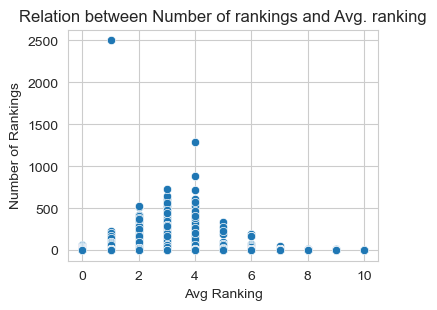

In [65]:
# sns setup
plt.figure(figsize=(4, 3))  # Adjust the figure size
sns.set_style("whitegrid")  # Add a light grid

# Graph the relation between avg ranking and number of rankings using Seaborn
sns.scatterplot(y='book_ratings_count', x='book_ratings_avg', data=df_book_rating)
plt.title('Relation between Number of rankings and Avg. ranking')
plt.ylabel('Number of Rankings')
plt.xlabel('Avg Ranking')
plt.show()

We expected higher rated books to have 

#### 7.2 Books and age:

In [ ]:
# avg book rating per age
result = session.execute("""
        SELECT isbn, age, AVG(book_rating), COUNT(book_rating)
        FROM books.books_rated_by_user
        GROUP BY isbn;
                """)
result.all()

#### 7.3 Users behaviour:

In [67]:
# find locations of users with most rankings
result = session.execute("""
        SELECT user_id, location, COUNT(book_rating) AS rating_count
        FROM users_by_rated_books
        GROUP BY user_id;
                """)